## Fitování multiperiodického signalu s šumem  ##

In [51]:
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt

from IPython.display import Image
from IPython.display import display,Math,Latex
from IPython.display import HTML


Jeden z nejčastějších úkolů spočívá v proložení modelu naměřenými daty a to nejen v astronomii.
Následující příklad sleduje postup uveřejněný v článku [Charbonneau](http://articles.adsabs.harvard.edu/full/1995ApJS..101..309C) jako jeden z demonstračních příkladů užití genetického algoritmu v praxi.

In [52]:
from IPython.display import HTML
HTML('<iframe src=http://adsabs.harvard.edu/full/1995ApJS..101..309C width=1200 height=350></iframe>')

Uvažme multiperiodický signál, který je definován $N$-násobnou trojicí čísel $(A_k,P_k,\varphi_k)$ a jednou konstantou $A_0$. Celkově máme tedy $3N-1$. Namodelujeme si syntetická data s použitím vztahu

$$
f(t) = A_0 + \sum_{k=1}^{N} A_k \sin{(\frac{2\pi t}{P_k}+\varphi_k)}
$$

pro zvolené hodnoty $N=5$, $A_0 = 5$ a

$$
A_k = [0.8,0.75,0.5,0.4,0.85],
$$

$$
P_k=[9.6,12.,18.,21.6,30.0],
$$

$$
\varphi_k=2\pi([0.4,0.15,0.1,0.2,0.25])
$$

Časový interval uvažujeme $t = 0\dots240$. K syntetickému signálu přidáme také umělý šum s hladinou úrovně šumu $\sigma = 1/\sqrt{12}$.

In [55]:
x_observe = np.linspace(0,240,1000)

A_k = np.array([0.8,0.75,0.5,0.4,0.85])
P_k = np.array([9.6,12.,18.,21.6,30.0])
phi_k = np.array([0.4,0.15,0.1,0.2,0.25])*2.0*np.pi
A0 = 5.0

def signal(A_k,P_k,phi_k,A0,x):
    
    y =np.zeros(np.size(x))

    for i in range(np.size(A_k)):
        y = y + A_k[i]*np.sin(x*np.pi*2.0/P_k[i]+phi_k[i])
        
    return y + A0

noise = np.random.normal(0.,1./np.sqrt(12.),np.size(x_observe))

y_observe = signal(A_k,P_k,phi_k,A0,x_observe) + noise

Výsledná syntetická data si zobrazíme graficky

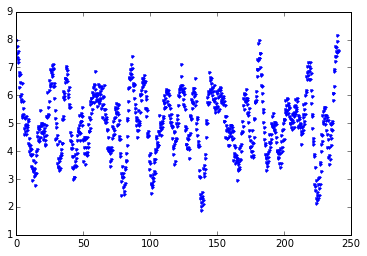

In [56]:
plt.plot(x_observe,y_observe,'.')
plt.show()

Nakonec je třeba také vytvořit umělé mezery v pozorování (například v důsledku střídání dne a noci). V našem případě tedy zvolíe pravidelné mezery s periodou $P=24$ a delkou trvání $\Delta t = P$.

In [57]:
# Gaps creation with duration delta time = 24

index_list = np.where(np.round(x_observe/24.0) % 2 == 0)
x_gaps = np.delete(x_observe,index_list)
y_gaps = np.delete(y_observe,index_list)

a opět si výsledná data zobrazíme 

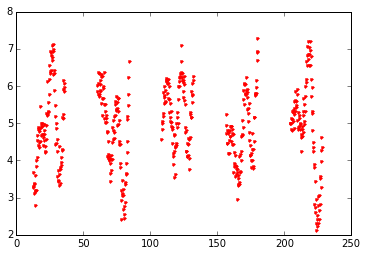

In [58]:
plt.plot(x_gaps,y_gaps,'r.')

Nyní přistoupíme k samotnému opačnému problému a budeme se snažit z těchto dat určit optimální model, tedy sadu $3N+1$
čísel. V praxi neznáme ani počet členů v sumě $N$, takže zvolíme $N=7$, což odpovídá situaci, kdy známe tuto informaci pouze přibližně, nikoliv však přesně. Použijeme opět knihovnu [PIKAIA](http://www.hao.ucar.edu/modeling/pikaia/pikaia.php) wrapované do jazyka PYTHON skrze knihovnu [ffnet](http://ffnet.sourceforge.net/_modules/pikaia.html). Nejdůležitějším prvkem je definice *fitnes* funkce, která určuje kriterium, podle kterého lze posoudit kvalitu modelu. PIKAIA používá maximalizaci, tedy čím lepší model, tím větši hodnota *fitnes* funkce. Všechny parametry jsou sloučeny do jediného vektoru o $3N$ složkách. *Fitnes* funkce používá ${\chi}^2$ kriterium:

$$
f_{\rm fit} = \sum_{j=1}^{K}\left(\frac{y_{th}-y_{obs}}{\sigma}\right)^2
$$

In [65]:
from ffnet.pikaia import pikaia

def fitnes(x):
    
    # Amplitudy
    A_k = x[:7]
    # Periody
    P_k = x[7:14]*100.0
    # Faze
    phi_k = x[14:21]
    A0 = x[21]*100.0
    
    y_model = signal(A_k,P_k,phi_k,A0,x_gaps)
    sigma = 1./np.sqrt(12.)
    
    fit_value = np.sum((y_model - y_gaps)**2/sigma)
    
    return 1./fit_value

In [66]:
n = 22
parameters = pikaia(fitnes, n, individuals=200, generations=400, digits=5, crossover=0.85, mutation=2, reproduction = 1, elitism = 1)

/Users/viktor/.virtualenvs/e-learn/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in divide
/Users/viktor/.virtualenvs/e-learn/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in sin


In [67]:
print 'P_k: ',parameters[7:14]*100.0
print 'A_k: ',parameters[:7]
print 'phi_k: ',parameters[14:21]
print 'A_0:',parameters[21]

P_k:  [ 20.88100052  29.29399872  19.49699974  17.99899864  90.2480011
  12.01099968   8.03399944]
A_k:  [ 0.5503      0.49465999  0.40776998  0.48133999  0.2121      0.84323996
  0.53169   ]
phi_k:  [ 0.0985      0.79962999  0.61904001  0.62456     0.04317     0.34006998
  0.00343   ]
A_0: 0.04946


## Určení orbitálních parametrů dvojhvězdy ##

Dalším příkladem, na kterým lze demonstrovat schopnosti optimalizace pomocí genetického algoritmu je určení orbitálních parametrů dvojhvězdného systému z určené křivky radiálních rychlostí. Vhodným zvoleným systémem bude 
$\eta$ Bootis, příslušné změřené radiální rychlosti jsou převzaty z článku [Bertiau (1957)](http://articles.adsabs.harvard.edu/full/1957ApJ...125..696B).

In [4]:
from astropy.table import Table

t = Table.read('radial_velocity.txt', format='ascii.commented_header')
t.pprint()

   HJD     Phase   RV 
--------- ------- ----
 17710.75 446.366 -0.1
 17716.68 452.296  2.9
 17795.58  37.023  9.0
 17968.84 210.283 -3.8
 17970.88 212.323 -3.5
 17989.94 231.383 -5.2
  17996.8 238.243 -6.8
 18031.91 273.353 -7.2
 18066.78 308.223 -6.7
 18085.67 327.113 -7.7
      ...     ...  ...
31834.992 239.591 -3.9
31853.038 257.637 -4.2
31881.016 285.615 -4.6
31924.876 329.475 -6.1
31946.808 351.407 -5.5
31977.728 382.327 -4.1
31999.697 404.296 -2.3
32032.681  437.28  1.7
32050.672 455.271  3.0
32072.651  477.25  8.6
 32365.71 276.136 -4.5
Length = 114 rows


Z tabulky si zjistíme hodnotu radiální rychlosti $V_j^{\text{obs}}$ pro všechny časové okamžiky $t_j$ z intervalu $ j = 0 \dots N$

Number of observed points 114  t_0:  14035.794   min(V): -7.7  max(V): 12.0


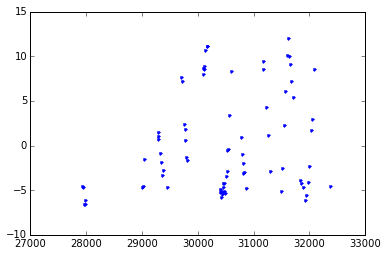

In [5]:
V_obs = np.array(t['RV'])
time = np.array(t['HJD'])

# Number of observation points
N = np.size(time)
t_0 = np.min(time)
min_V = np.min(V_obs)
max_V = np.max(V_obs)
sigma = np.std(V_obs)

plt.xlim(27000,33000)
plt.plot(time,V_obs,'.',color='blue')

print 'Number of observed points',N,' t_0: ',t_0,'  min(V):',min_V,' max(V):',max_V

Křivka změn radiálních rychlostí hvězdy v dvojhvězdném systému je určena vztahem

$$
V(t) = V_0+K(\cos{(\omega+v(t)}+e\cos{(\omega)}),
$$

přičemž předpokládáme, radiální rychlost byla již opravena o pohyb Země kolem Slunce. $V_0$ je radiální rychlost hmotného středu binárního systému, $\omega$ je délka perihelu, $v(t)$ je prává anomálie. $K$ amplituda rychlostí je funkcí

$$
K = \frac{2\pi}{P}\frac{a \sin i}{(1-e^2)^{1/2}},
$$

kde $P$ je orbitální perioda, $e$ excentricita, $a$ velikost hlavní poloosy a $i$ je inklinace. Velikost inklinace nejde určit z křivky radiálních rychlostí (pokud se nejedná o zákrytovou dvojvhězdu) a proto se většinou uvažuje 
$K$ jako samostatný parametr. Pravá anomálie je spjata s excentrickou anomálií

$$
\tan \frac{v}{2} = \sqrt{\frac{1+e}{1-e}}\tan{\frac{E}{2}}
$$

a zároveň excentrická anomálie je spjata Keplerovou rovnicí

$$
E - e\sin{E} = \frac{2\pi}{P}(t-\tau),
$$

kde $\tau$ je doba průchodu perihelem.


### Formulace problému pro GA ###

Nejprve je nutné definovat vektor **u** obsahující parametry problému, kterými jsou 

1. $P$, orbitální perioda [juliánsky den]
2. $\tau$, čas průchodu periastrem [juliánský den]
3. $\omega$, delka perihelu [radián]
4. $e$, excentricita []
5. $K$, amplituda rychlosti [km.s^(-1)]
6. $V_0$, systémová radiální rychlost [km.s^(-1)]

které budeme muset ještě normaizovat, protože knihovna PIKAIA prohledává parametrický prostor v rozmezí $[0,1]$. K normalizaci využijeme fyzikálních a matematických omezení kladených na jednotlivé parametry. 

V případě excentricity je situace jednoduchá, podle definice velikost excentricity leží v intervalu $0 \leq e \leq 1$. Podobné omezení platí pro délku perihelu $0 \leq \omega \leq 2\pi$. Pohledem na graf závislosti radiální rychlosti na čase lze zhruba odhadnout, rozmezí pro periodu $200 \leq P \leq 800$. Čas průchodu perihelem je svázán s odhadem periody a začátkem pozorování $ t_0 \leq \tau \leq t_0 + P$. Amplituda rychlosti by neměla být větší než rozdíl mezi maxiální a minimální hodnotou rychlosti určenou z napozorovaných dat, $ 0 \leq K \leq \text{max}(V_j)-\text{min}(V_j)$ a obdobně pro systémovou rychlost z dat vyplývá, že $\text{min}(V_j) \leq V_0 \leq \text{max}(V_j)$

Našim úkolem bude najít takový vektor ${\bf u}(P,\tau,\omega,e,K,V_0)$ který minimalizuje $\chi^2$ pro soubor $N$ napozorovaných dat $V_j^{\text{obs}}$ spojených s odhadem chyb $\sigma_i$. Konkrétně

$$
\chi^2({\bf u})=\frac{1}{N-6}\sum_{j=0}^{N-1}\left( \frac{V_j^{\text{obs}}-V(t_j,{\bf u})}{\sigma_j} \right)^2,
$$

kde normalizační faktor $(N-6)^{-1}$ odpovídá stupňům volnosti systému. 

In [25]:
from PyAstronomy import pyasl

ks = pyasl.MarkleyKESolver()

def Kepler_equation(mean_anomaly,e):
    excentric_anomaly = np.empty(np.size(mean_anomaly))
    for i in range(np.size(mean_anomaly)):
        excentric_anomaly[i] = ks.getE(mean_anomaly[i], e)
    return excentric_anomaly

def true_anomaly(E_anomaly,e):
    factor = np.sqrt(1+e)/np.sqrt(1-e)
    return 2.0*np.arctan(factor*np.tan(E_anomaly/2.0))

def chi_quadrat(u):
    
    difference_quadrat = ((V_obs - V_predicted(u,time))/sigma)**2
    
    return 1./(N-6)*np.sum(difference_quadrat)

def fitnes(u):
    return 1./chi_quadrat(u)

def V_predicted(u,t):
    P = 200.0+u[0]*(800.0-200.0)
    tau = t_0+P*u[1]
    omega = u[2]*2.0*np.pi
    e = u[3]
    K = u[4]*(max_V - min_V)
    V_0 = min_V + u[5]*(max_V-min_V)
    
    mean_anomaly = 2.*np.pi/P*(t-tau)
    E_anomaly = Kepler_equation(mean_anomaly,e)
    v = true_anomaly(E_anomaly,e)
    
    return V_0+K*(np.cos(omega+v)+e*np.cos(omega))


In [26]:
mean_an = np.array([1.2,1.3])
print mean_an,np.size(mean_an)
print mean_an
e = 0.205635
print (Kepler_equation(mean_an,e))
print sigma

[ 1.2  1.3] 2
[ 1.2  1.3]
[ 1.40273789  1.50519265]
5.67622787971


In [27]:
from ffnet.pikaia import pikaia

n = 6
parameters = pikaia(fitnes, n, individuals=100, generations=100, digits=2, crossover=0.85, mutation=2, reproduction = 1, elitism = 1)

In [34]:
print 'Best fitness value: ',fitnes(parameters)

def decode_u(u):
    P = 200.0+u[0]*(800.0-200.0)
    tau = t_0+P*u[1]
    omega = (u[2]*2.0*np.pi)*180.0/np.pi
    e = u[3]
    K = u[4]*(max_V - min_V)
    V_0 = min_V + u[5]*(max_V-min_V)
    return (P,tau,omega,e,K,V_0)

P,tau,omega,e,K,V_0 = decode_u(parameters)

print ("Perioda: %0.2f [day] Tau: %0.2f [day] Omega: %0.2f [deg]  Excentricita: %0.2f\
 K-rychlost: %0.2f [km/s]  Gammma rychlost: %0.2f[km/s]") % (P,tau,omega,e,K,V_0)


Best fitness value:  2.79616761789
Perioda: 512.00 [day] Tau: 14245.71 [day] Omega: 349.20 [deg]  Excentricita: 0.19 K-rychlost: 6.89 [km.s^(-1)]  Gammma rychlost: 0.77[km.s^(-1)]


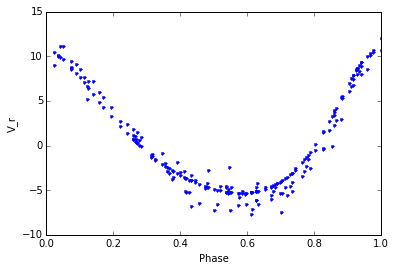

In [49]:
from ipywidgets import interact

@interact(P=(450,550), tau = (14250,14350), omega=(np.pi, 2.0*np.pi), e = (0.15,0.35), K =(5,9), V_0 =(0.6,1.1))
def plot_radial_velocity(P = P, tau = tau, omega = omega, e = e, K = K, V_0 = V_0):

    time_pred = time
    
    mean_anomaly = 2.*np.pi/P*(time_pred-tau)
    E_anomaly = Kepler_equation(mean_anomaly,e)
    v = true_anomaly(E_anomaly,e)
    
    # Theoretical profile
    y_pred = V_0+K*(np.cos(omega+v)+e*np.cos(omega))
    x_pred = time_calcul/P - np.fix(time_calcul/P)
    
    # Observed profile
    y = V_obs
    x = time/P - np.fix(time/P)
    
    plt.xlabel('Phase')
    plt.ylabel('V_r')
    plt.plot(x,y,'x',color = 'red')
    plt.plot(x_pred,y_pred,'.',color='blue')
    plt.plot()
    plt.show()
    return


Náš výsledek srovnáme s parametry publikovanými v článku [Bertiau (1957)](http://articles.adsabs.harvard.edu/full/1957ApJ...125..696B)

$ P = 493.173 \pm 0.05 $ [days]

$ T = 2428136.19 \pm 2.4$ [days] 

$ \omega = 326.33$ [deg] 

$ e = 0.2575 \pm 0.009 $ 

$ K = 8.42 \pm 0.08 $ [km/s]

$ \gamma = 1.01 \pm $ [km/s]